Loading processed data...
Loading original data for feature extraction...
Loading KuaiRec datasets...
Loading interaction matrices...
Loading social network data...
Loading item categories...
Loading user features...
Loading item daily features...
All data loaded successfully!

Creating user features...
User features sample:
   user_id  watch_ratio_mean  watch_ratio_std  watch_ratio_min  \
0       14          0.997286         1.035473              0.0   
1       19          0.845163         0.419080              0.0   
2       21          0.949279         0.978718              0.0   
3       23          1.042769         1.581070              0.0   
4       24          0.860268         1.731859              0.0   

   watch_ratio_max  watch_ratio_count  play_duration_mean  play_duration_sum  \
0        26.705261               2657         9644.608205           25625724   
1         5.691734               2651         7945.237646           21062825   
2        37.915704               264

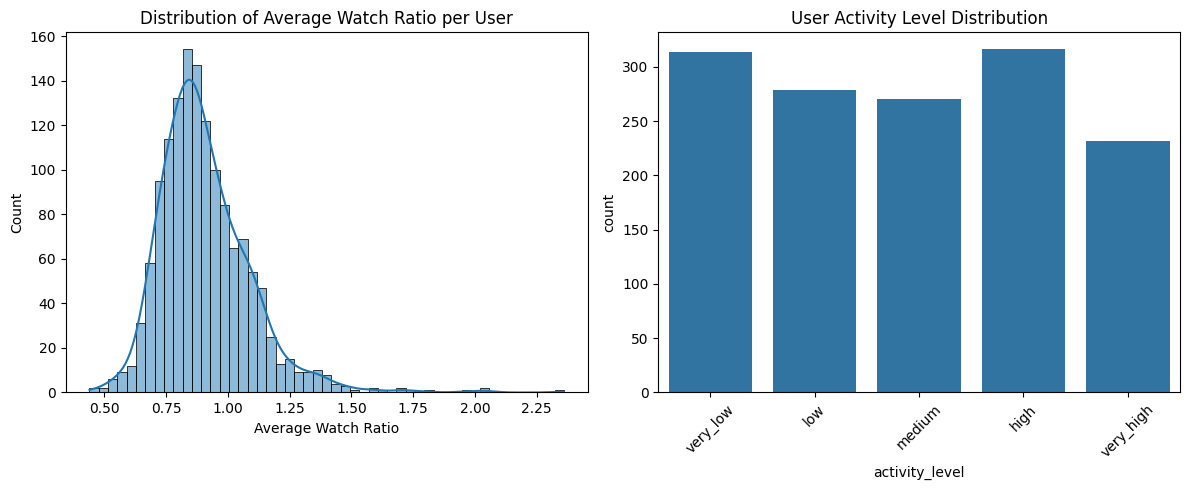


Creating item features...
Item features sample:
   video_id  watch_ratio_mean  watch_ratio_std  watch_ratio_min  \
0       103          0.785161         0.453749              0.0   
1       109          1.059498         0.609040              0.0   
2       120          1.363610         1.734234              0.0   
3       122          0.870577         0.711269              0.0   
4       128          0.783104         0.723892              0.0   

   watch_ratio_max  watch_ratio_count  play_duration_mean  play_duration_sum  \
0         4.650680               1134         8087.153439            9170832   
1         7.441998               1134         8229.122575            9331825   
2        40.105154               1147         8557.188317            9815095   
3        10.884631               1147         8474.197036            9719904   
4        12.485049               1122         8170.909982            9167761   

  popularity  engagement_score  ...  category_29  category_30  play

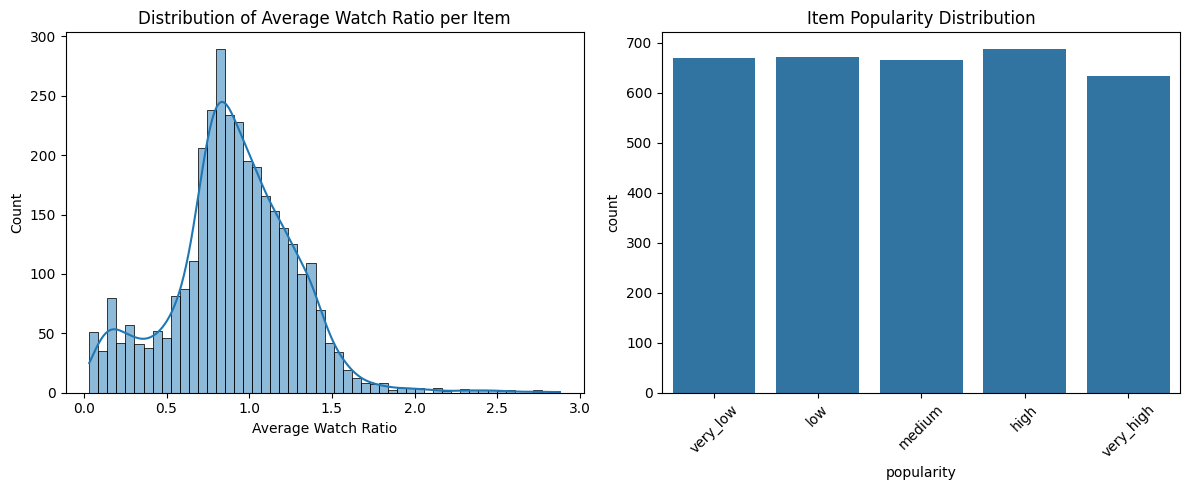


Building interaction matrix...
Interaction matrix shape: (1411, 3327)
Interaction matrix density: 79.71%


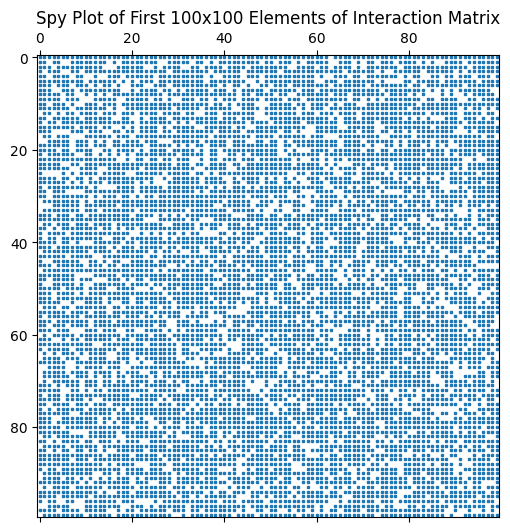


Creating interaction features...
Training features sample:
   user_id  video_id  play_duration  video_duration                     time  \
0       14      8608           8540           30200   2020-07-25 23:39:01.14   
1       14      5615          22607           21067  2020-07-20 19:03:48.605   
2       14      7731          11490            6700  2020-08-16 23:15:07.791   
3       14       634           8611            5800  2020-07-20 19:00:45.893   
4       14      1907          11520            7918  2020-07-20 22:19:00.131   

         date     timestamp  watch_ratio                      datetime  hour  \
0  2020-07-25  1.595692e+09     0.282781 2020-07-25 15:39:01.140000105  15.0   
1  2020-07-20  1.595243e+09     1.073100 2020-07-20 11:03:48.605000019  11.0   
2  2020-08-16  1.597591e+09     1.714925 2020-08-16 15:15:07.790999889  15.0   
3  2020-07-20  1.595243e+09     1.484655 2020-07-20 11:00:45.892999887  11.0   
4  2020-07-20  1.595255e+09     1.454913 2020-07-20 14:19:0

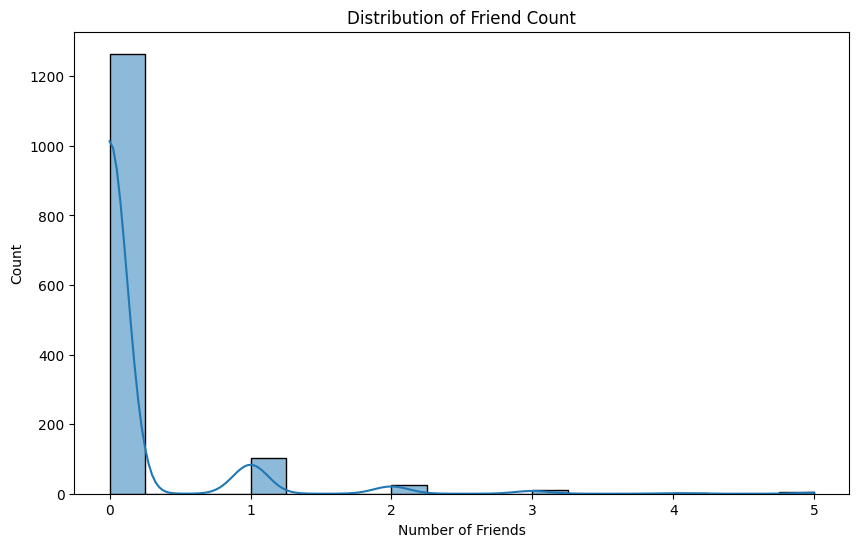


Saving all features...
Saved user_features with shape (1411, 41)
Saved item_features with shape (3327, 49)
Saved train_features with shape (3741835, 21)
Saved test_features with shape (934735, 21)
Saved social_features with shape (1411, 4)

=== Feature Engineering Summary ===
1. User Features:
   - 1411 users with 41 features
   - Key features include: average watch ratio, activity level, user demographics

2. Item Features:
   - 3327 items with 49 features
   - Key features include: popularity, engagement score, categories

3. Interaction Matrix:
   - Shape: 1411 users × 3327 items
   - Density: 79.71%

4. Interaction Features:
   - Training set: 3741835 interactions with 21 features
   - Test set: 934735 interactions with 21 features

5. Social Features:
   - 1411 users with 4 features
   - Features include: friend count, friend average watch ratio, similarity with friends

All features have been saved to the processed directory for use in model development.


In [1]:
# 2_feature_engineering.ipynb

# Feature Engineering for KuaiRec Recommender System
# ==================================================
#
# This notebook covers the second task of the project:
# 1. Create meaningful features from interaction and metadata
# 2. Build user-item interaction matrix
# 3. Extract time-based and popularity-based features

# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import pickle
from datetime import datetime
from tqdm import tqdm

# Add the src directory to the path so we can import our modules
sys.path.append(os.path.abspath("../"))
from src.data_processing import load_kuairec_data
from src.feature_engineering import (
    create_user_features,
    create_item_features,
    create_interaction_features,
    build_interaction_matrix,
    extract_social_features,
    save_features
)

# Load processed data
print("Loading processed data...")
processed_dir = "../data/processed"

small_matrix = pd.read_csv(os.path.join(processed_dir, "small_matrix_processed.csv"), low_memory=True)
train_df = pd.read_csv(os.path.join(processed_dir, "train_interactions.csv"), low_memory=True)
test_df = pd.read_csv(os.path.join(processed_dir, "test_interactions.csv"), low_memory=True)

# Convert datetime columns
datetime_cols = ['datetime']
for col in datetime_cols:
    if col in train_df.columns:
        train_df[col] = pd.to_datetime(train_df[col])
    if col in test_df.columns:
        test_df[col] = pd.to_datetime(test_df[col])

# Also load the original data for additional features
print("Loading original data for feature extraction...")
data = load_kuairec_data()
social_network = data["social_network"]
item_categories = data["item_categories"]
user_features = data["user_features"]
item_daily_features = data["item_daily_features"]

# 1. Create User Features
# -----------------------
print("\nCreating user features...")
user_features_df = create_user_features(train_df, user_features)

print("User features sample:")
print(user_features_df.head())
print(f"User features shape: {user_features_df.shape}")

# Visualize user feature distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(user_features_df['watch_ratio_mean'], kde=True)
plt.title('Distribution of Average Watch Ratio per User')
plt.xlabel('Average Watch Ratio')

plt.subplot(1, 2, 2)
sns.countplot(x='activity_level', data=user_features_df, order=['very_low', 'low', 'medium', 'high', 'very_high'])
plt.title('User Activity Level Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Create Item Features
# -----------------------
print("\nCreating item features...")
item_features_df = create_item_features(train_df, item_categories, item_daily_features)

print("Item features sample:")
print(item_features_df.head())
print(f"Item features shape: {item_features_df.shape}")

# Visualize item feature distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(item_features_df['watch_ratio_mean'], kde=True)
plt.title('Distribution of Average Watch Ratio per Item')
plt.xlabel('Average Watch Ratio')

plt.subplot(1, 2, 2)
sns.countplot(x='popularity', data=item_features_df, order=['very_low', 'low', 'medium', 'high', 'very_high'])
plt.title('Item Popularity Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Create Interaction Matrix
# ----------------------------
print("\nBuilding interaction matrix...")
interaction_matrix, user_indices, item_indices = build_interaction_matrix(train_df, rating_col='watch_ratio')

# Save the indices for later use
with open(os.path.join(processed_dir, "user_indices.pkl"), 'wb') as f:
    pickle.dump(user_indices, f)
with open(os.path.join(processed_dir, "item_indices.pkl"), 'wb') as f:
    pickle.dump(item_indices, f)

# Save the sparse matrix
sparse.save_npz(os.path.join(processed_dir, "interaction_matrix.npz"), interaction_matrix)

print(f"Interaction matrix shape: {interaction_matrix.shape}")
print(f"Interaction matrix density: {interaction_matrix.nnz / (interaction_matrix.shape[0] * interaction_matrix.shape[1]) * 100:.2f}%")

# Visualize matrix density
plt.figure(figsize=(10, 6))
plt.spy(interaction_matrix[:100, :100], markersize=2)
plt.title('Spy Plot of First 100x100 Elements of Interaction Matrix')
plt.show()

# 4. Create interaction features for training data
# ------------------------------------------------
print("\nCreating interaction features...")
train_features_df = create_interaction_features(train_df, user_features_df, item_features_df)

print("Training features sample:")
print(train_features_df.head())
print(f"Training features shape: {train_features_df.shape}")

# Also create features for test data
test_features_df = create_interaction_features(test_df, user_features_df, item_features_df)
print(f"Test features shape: {test_features_df.shape}")

# 5. Extract social network features (if available)
# -------------------------------------------------
print("\nExtracting social network features...")
social_features_df = extract_social_features(train_df, social_network)

print("Social features sample:")
print(social_features_df.head())
print(f"Social features shape: {social_features_df.shape}")

# Visualize friend count distribution
plt.figure(figsize=(10, 6))
sns.histplot(social_features_df['friend_count'], kde=True, bins=20)
plt.title('Distribution of Friend Count')
plt.xlabel('Number of Friends')
plt.show()

# 6. Save all features
# --------------------
print("\nSaving all features...")
features_dict = {
    "user_features": user_features_df,
    "item_features": item_features_df,
    "train_features": train_features_df,
    "test_features": test_features_df,
    "social_features": social_features_df
}

save_features(features_dict, processed_dir)

# 7. Summary of features created
# -----------------------------
print("\n=== Feature Engineering Summary ===")

print("1. User Features:")
print(f"   - {user_features_df.shape[0]} users with {user_features_df.shape[1]} features")
print("   - Key features include: average watch ratio, activity level, user demographics")

print("\n2. Item Features:")
print(f"   - {item_features_df.shape[0]} items with {item_features_df.shape[1]} features")
print("   - Key features include: popularity, engagement score, categories")

print("\n3. Interaction Matrix:")
print(f"   - Shape: {interaction_matrix.shape[0]} users × {interaction_matrix.shape[1]} items")
print(f"   - Density: {interaction_matrix.nnz / (interaction_matrix.shape[0] * interaction_matrix.shape[1]) * 100:.2f}%")

print("\n4. Interaction Features:")
print(f"   - Training set: {train_features_df.shape[0]} interactions with {train_features_df.shape[1]} features")
print(f"   - Test set: {test_features_df.shape[0]} interactions with {test_features_df.shape[1]} features")

print("\n5. Social Features:")
print(f"   - {social_features_df.shape[0]} users with {social_features_df.shape[1]} features")
print("   - Features include: friend count, friend average watch ratio, similarity with friends")

print("\nAll features have been saved to the processed directory for use in model development.")